
## Содержание<a class="tocSkip">

1. [Изучение данных из файла](#opening)
    - [Вывод](#opening_conclusion)
    
    
2. [Предобработка данных](#preprocessing)
    - [Вывод](#preprocessing_conclusion)  
        
 
3. [Анализ данных](#analysis)
    - [Распределение просмотров по дням](#views_by_day)
    - [Очистка выбросов](#emissions)
    - [Распределение средних eCPM пользователей](#mean_ecpm_by_user)
    - [Распределение по городам](#mean_ecpm_by_cities)
    - [Распределение по операционным системам (ОС)](#by_os)
    - [Процент доходов, содержащий информацию о городе пользователя](#city_percent)   
    - [Распределение доходов по времени суток](#day_time)
    - [Распределение выручки по устройствам](#revenue_by_device)
    - [Выручка от продолжительности сессии](#revenue_by_length)    
    - [Выручка по рекламным сетям](#revenue_by_net)
    - [Вывод](#analysis_conclusion)


4. [Общий вывод](#conclusion)

# Исследование данных о показах рекламы в мобильной игре

<br>
Имея данные о показах рекламы в мобильной игре, понять, на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров.

<a id="opening"></a>
## Изучение данных из файла

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

Прочитаем имеющийся в нашем распоряжении файл, посмотрим сводную информацию и первые 5 строк.

In [2]:
def open_csv(file_name):
    try:
        df = pd.read_csv(r"/datasets/{}".format(file_name))
    except FileNotFoundError:
        df = pd.read_csv(r"C:\Users\79822\python\datasets\{}".format(file_name))
    return(df)

In [3]:
df = open_csv('us events ad_revenue filtered 03.02-07.02.csv')

In [4]:
def description(dict_df): #напишем функцию для краткого описания датафреймов
    for name_df, df in dict_df.items():
        print('Первые 5 строк и сводная информация по файлу', name_df)
        display(df.head())
        df.info()
        print('Количество строк-дубликатов в датафрейме', name_df, 'равно', df.duplicated().sum())
        print('_'*100)

In [5]:
description({'df': df,
            })

Первые 5 строк и сводная информация по файлу df


,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

<a id="opening_conclusion"></a>
### Вывод

Представленный датасет содержит информацию о показах рекламы и доходов от показов в виде 15 колонок и 860079 строк.

Информация, содержащаяся в колонках:
- уникальный номер пользователя;
- версия операционной системы;
- производитель, модель, тип, локализация устройства;
- название события (показа рекламы);
- информация о показе рекламы;
- дата показа рекламы;
- дата получения вознаграждения;
- тип соединения;
- название оператора;
- код страны;
- город.


Колонку `event_json` необходимо разделить еще на 6 колонок:
- ad_type – формат рекламы (int, banner или rv);
- placement – когда/где был показ рекламы в игре;
- view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров);
- revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000);
- ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера;
- network_name – рекламная сеть, от которой был показ.

<a id="preprocessing"></a>
## Предобработка данных

Необходимо:
- разделить колонку `event_json`;
- привести к формату даты и времени соответствующие колонки.

In [6]:
df = df.join(df['event_json'].str.split(',', expand=True)) #разобьем колонку event_json

In [7]:
#создадим список названий новых колонок
columns_event_json_list = ["ad_type","placement","view_index",
                           "session_view_index","cur_ticks","session_length",
                           "revenue","ads_ltv","ecpm_sma","normalized_ecpm_sma",
                           "value","currency","ad_country_code","network_name",
                           "ad_unit_id","ad_network_placement","creativeId"]

In [8]:
#переименуем новые колонки
df = df.rename(columns=dict(zip(range(0,17), columns_event_json_list)))

In [9]:
def update_cells(cell): #функция для очистки содержимого новых колонок от лишних символов
    cell = cell.split(':')
    cell = cell[-1]
    if '"' in cell:
        cell = cell.replace('"', '')
    if '{' in cell:
        cell = cell.replace('{', '')
    if '}' in cell:
        cell = cell.replace('}', '')
    return(cell)

In [10]:
for col in columns_event_json_list:
    df[col] = df[col].map(update_cells)

In [11]:
#удалим лишнюю колонку
df = df.drop('event_json', axis=1)

In [12]:
#преобразуем формат колонок datetime
df['event_datetime'] = pd.to_datetime(df['event_datetime'])
df['event_receive_datetime'] = pd.to_datetime(df['event_receive_datetime'])

In [13]:
#преобразуем формат колонок с вещественными числами
df = df.astype({col:'float' for col in ["session_length","revenue","ads_ltv","ecpm_sma","normalized_ecpm_sma","value"]})

<a id="preprocessing_conclusion"></a>
### Вывод

Разбили колонку `event_json` на 17 новых и преобразовали колонки формата даты и времени, а также колонки формата вещественных чисел.

<a id="analysis"></a>
## Анализ данных

<a id="views_by_day"></a>
### Распределение просмотров по дням

Посмотрим, за какие даты, представлен датасет.

In [14]:
print('Дата начала:', df.event_datetime.dt.date.min())
print('Дата окончания:', df.event_datetime.dt.date.max())

Дата начала: 2022-01-29
Дата окончания: 2022-02-07


Рассмотрим распределение количества событий по датам.

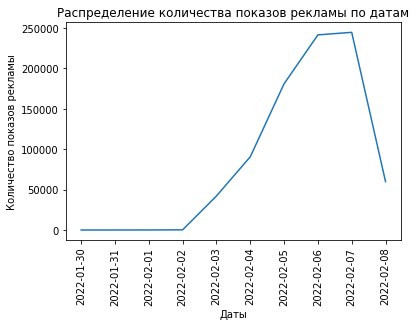

In [15]:
plt.plot(df.pivot_table(index=df['event_datetime'].dt.round('1d'), values='event_name', aggfunc='count'))
plt.title('Распределение количества показов рекламы по датам')
plt.xlabel('Даты')
plt.ylabel('Количество показов рекламы')
plt.xticks(rotation=90)
plt.show()

До 02 февраля очень мало показов рекламы - возможно игра только запускалась, после этого заметный рост просмотров, после 7 февраля количество показов резко сократилось (возможно логи еще не подгрузились).

Проверим, одинаково ли распреление рекламы по типам по датам.

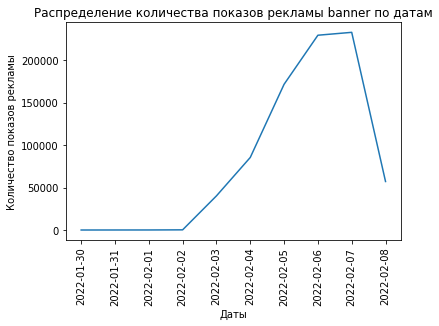

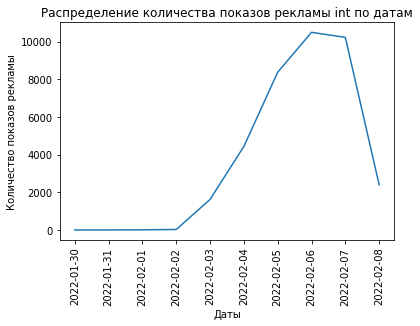

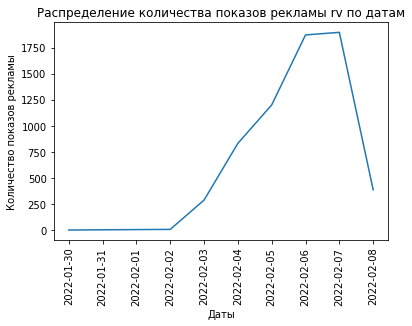

In [16]:
for ad_type in df.ad_type.unique():
    plt.plot(df[df['ad_type']==ad_type].pivot_table(index=df['event_datetime'].dt.round('1d'), values='event_name', aggfunc='count'))
    plt.title(f'Распределение количества показов рекламы {ad_type} по датам')
    plt.xlabel('Даты')
    plt.ylabel('Количество показов рекламы')
    plt.xticks(rotation=90)
    plt.show()

Форма графика распределения количества рекламы по типам по датам примерно одинакова - это говорит о том, что частота просмотров разных видов рекламы растет (и, возможно, уменьшается) пропорционально - значит нет необходимости удалять данные за какие-то даты.

<a id="emissions"></a>
### Очистка выбросов

Рассмотрим, какие значения принимает выручка за рекламу.

In [17]:
df.groupby('ad_type')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
ad_type,,,,,,,,
banner,815984.0,0.000744,0.001401,6.375000e-08,0.000042,0.000494,0.000531,0.063750
int,37613.0,0.036210,0.048187,0.000000e+00,0.011966,0.021399,0.037048,0.937196
rv,6482.0,0.065051,0.075927,1.606661e-04,0.028025,0.031469,0.080640,0.916206


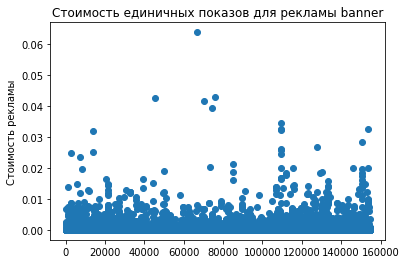

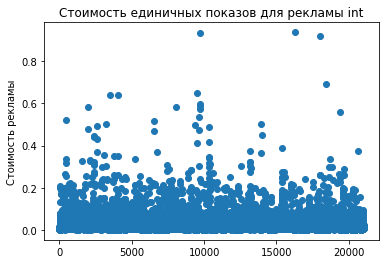

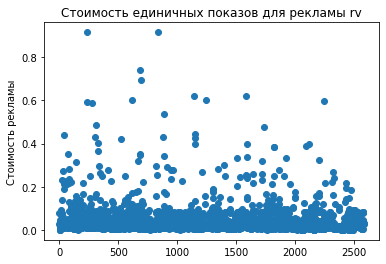

In [18]:
for ad_type in df.ad_type.unique():
    x_values = pd.Series(range(0, df[df['ad_type']==ad_type]['revenue'].nunique()))
    plt.scatter(x_values, df[df['ad_type']==ad_type]['revenue'].unique())
    plt.ylabel('Стоимость рекламы')
    plt.title(f'Стоимость единичных показов для рекламы {ad_type}')
    plt.show()

In [19]:
for ad_type in df.ad_type.unique():
    print(f'95-персентиль стоимости показов рекламы {ad_type}:',\
      round(np.percentile(df[df['ad_type']==ad_type]['revenue'], 95), 4))
    print(f'99-персентиль стоимости показов рекламы {ad_type}:',\
      round(np.percentile(df[df['ad_type']==ad_type]['revenue'], 99), 4))
    print()

95-персентиль стоимости показов рекламы banner: 0.0023
99-персентиль стоимости показов рекламы banner: 0.007

95-персентиль стоимости показов рекламы int: 0.131
99-персентиль стоимости показов рекламы int: 0.1975

95-персентиль стоимости показов рекламы rv: 0.2117
99-персентиль стоимости показов рекламы rv: 0.2772



Максимальное значение стоимости рекламы для баннеров 0.064, однако это - единичное значение, 99% значений же укладываются в 0.007, будет целесообразным исключить из анализа значения выше этого предела, а эти значения проанализировать отдельно.

Аналогично для рекламы int дороже 0.1975 и рекламы rv дороже 0.2772.

In [20]:
df_normal_ads = df[((df['ad_type']=='banner')&(df['revenue']<=np.percentile(df[df['ad_type']=='banner']['revenue'], 99)))|
                  ((df['ad_type']=='int')&(df['revenue']<=np.percentile(df[df['ad_type']=='int']['revenue'], 99)))|
                  ((df['ad_type']=='rv')&(df['revenue']<=np.percentile(df[df['ad_type']=='rv']['revenue'], 99)))]

<a id="mean_ecpm_by_user"></a>
### Распределение средних eCPM пользователей

Посмотрим распределение средних eCPM пользователей.

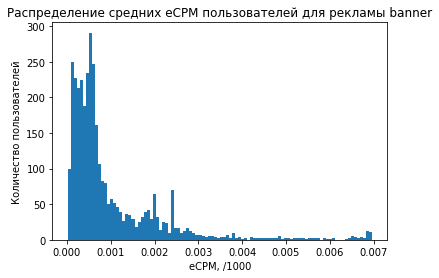

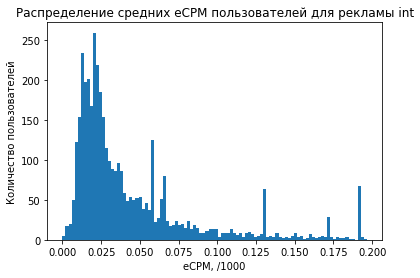

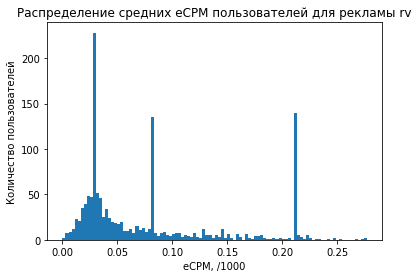

In [21]:
for ad_type in df_normal_ads.ad_type.unique():
    plt.hist(df_normal_ads[df_normal_ads['ad_type']==ad_type].groupby('profile_id').agg({'revenue':'mean'}), bins=100)
    plt.title(f'Распределение средних eCPM пользователей для рекламы {ad_type}')
    plt.xlabel('eCPM, /1000')
    plt.ylabel('Количество пользователей')
    plt.show()

Наибольший доход за 1000 показов рекламы встречается для рекламы rv (Rewarded video), однако количество пользователей, смотрящих такую рекламу меньше, чем для двух других видов.

Большее количество пользователей видит Interstitial рекламу - int. 

Самое большое количество просмотров баннеров, но эта реклама самая дешевая.

<a id="mean_ecpm_by_cities"></a>
### Распределение по городам

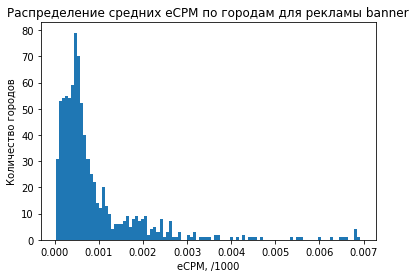

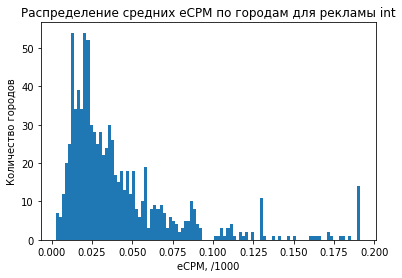

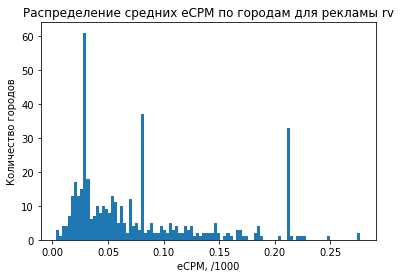

In [22]:
for ad_type in df_normal_ads.ad_type.unique():
    plt.hist(df_normal_ads[df_normal_ads['ad_type']==ad_type].groupby('city').agg({'revenue':'mean'}), bins=100)
    plt.title(f'Распределение средних eCPM по городам для рекламы {ad_type}')
    plt.xlabel('eCPM, /1000')
    plt.ylabel('Количество городов')
    plt.show()

Вцелом разбивка по городам дает такое же представление о eCPM: наиболее дорогая реклама RV, однако ее меньше всего смотрят, немного менее доходная но более популярная реклама Int, наиболее часто встречается реклама Banner, но она - самая дешевая.

<a id="by_os"></a>
### Распределение по операционным системам (ОС)

Для начала проверим, какие устройства представлены в датасете.

In [23]:
df.device_manufacturer.unique()

array(['Samsung', 'Google', 'TCL', 'LG', 'OnePlus', 'Motorola',
       'Teracube', 'Lenovo', 'T-Mobile', 'Verizon Wireless', 'Xiaomi',
       'Alcatel', 'Cricket', 'Blu', 'Kyocera', 'Maxwest', 'Nokia', 'FIH',
       'Dish', 'Schok', 'deejoy', 'AT&T', 'Zte', 'Redmi', 'Yulong',
       'Wiko', 'Huawei', 'Onn (Walmart)', 'AEEZO', 'Asus', 'JOYAR',
       'POCO', 'Ulefone', 'Razer'], dtype=object)

Можно предположить, что все эти устройства работают на Andriod - значит можно группировать просто по версии ОС.

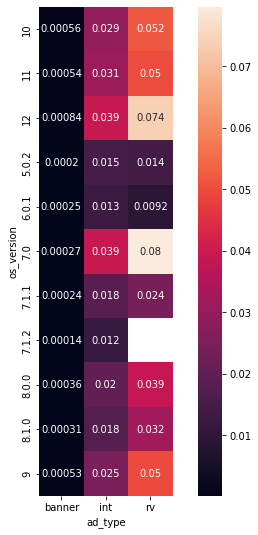

In [24]:
plt.figure(figsize=(9,9))  
sns.heatmap(df_normal_ads.pivot_table(
    index='os_version', columns='ad_type', values='revenue', aggfunc='mean').sort_index(), annot = True, square=True)
plt.show()

Кажется, наиболее выгодна реклама для версий ОС 12 и 7.0, проверим количество пользователей по группам.

In [25]:
df_normal_ads.os_version.value_counts()

12       402006
11       207419
10       150173
9         66425
8.1.0      9235
8.0.0      8013
7.0        4054
7.1.2      1811
7.1.1      1342
5.0.2       709
6.0.1       704
Name: os_version, dtype: int64

Наиболее выгодная реклама для версии 12 - как по средней выручке, так и по количеству пользователей.

<a id="city_percent"></a>
### Процент доходов, содержащий информацию о городе пользователя

In [26]:
print('Процент доходов, содержащий информацию по городе пользователя: {:.1%}'.format((len(df)-df.city.isna().sum())/len(df)))

Процент доходов, содержащий информацию по городе пользователя: 62.4%


<a id="day_time"></a>
### Распределение доходов по времени суток

Рассмотрим количество показов рекламы по часам.

In [27]:
df['local_event_datetime'] = df['event_datetime'] + pd.Timedelta(hours=-5) #приведем время к зимнему 
                                                                            #времени восточного побережья
df['local_event_hour'] = pd.DatetimeIndex(df['local_event_datetime']).hour #вынесем час отдельным столбцом

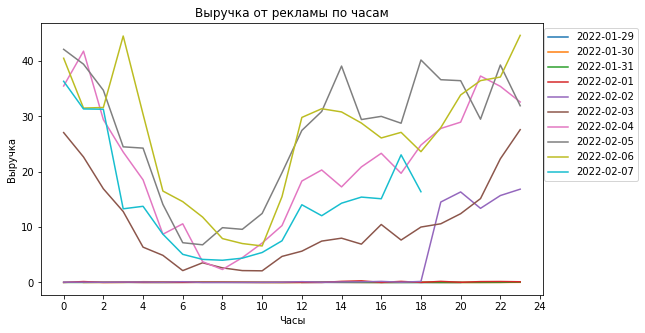

In [28]:
start_date = df.local_event_datetime.dt.date.min()
end_date = df.local_event_datetime.dt.date.max()
day_count = (end_date - start_date).days + 1

plt.figure(figsize=(9, 5))
for single_date in [d for d in (start_date + timedelta(n) for n in range(day_count)) if d <= end_date]:
    plt.plot(df[df['local_event_datetime'].dt.date==single_date].groupby('local_event_hour')['revenue'].sum())

plt.legend([d for d in (start_date + timedelta(n) for n in range(day_count)) if d <= end_date], loc=1, 
           bbox_to_anchor=(1.2, 1))
plt.title('Выручка от рекламы по часам')
plt.xlabel('Часы')
plt.ylabel('Выручка')
plt.xticks(range(0, 25, 2))
plt.show()

Таким образом прибыль в утренние часы меньше, чем в остальное время.

<a id="revenue_by_device"></a>
### Распределение выручки по устройствам

Рассмотрим, отличается ли выручка от рекламы в зависимости от устройства.

In [29]:
df_normal_ads.groupby('device_type')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
device_type,,,,,,,,
phone,827655.0,0.002548,0.012831,0.000000,0.000045,0.000494,0.000533,0.276948
tablet,24236.0,0.003353,0.015726,0.000001,0.000046,0.000497,0.000535,0.218358


Количество пользователей телефонов превышает количество пользователей планшетов более чем в 30 раз, но выручка от рекламы не зависит от устройства.

<a id="revenue_by_length"></a>
### Выручка от продолжительности сессии

Рассмотрим распределение стоимости рекламы от времени сессии по типам рекламы.

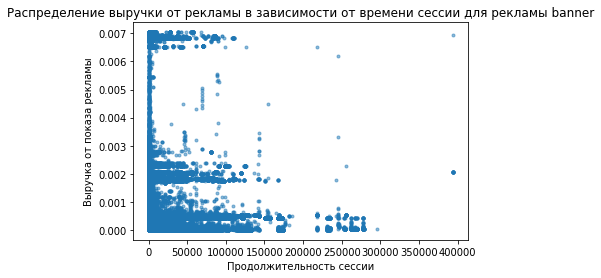

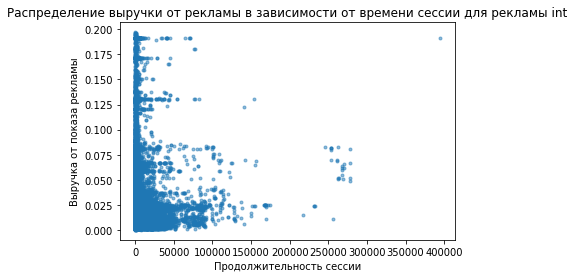

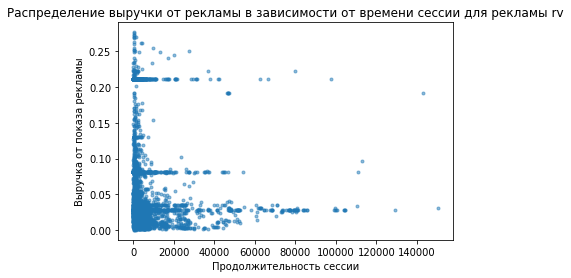

In [30]:
for ad_type in df_normal_ads.ad_type.unique():
    plt.plot(df_normal_ads[df_normal_ads['ad_type']==ad_type]['session_length'], 
             df_normal_ads[df_normal_ads['ad_type']==ad_type]['revenue'], '.', alpha=0.5)
    plt.title(f'Распределение выручки от рекламы в зависимости от времени сессии для рекламы {ad_type}')
    plt.xlabel('Продолжительность сессии')
    plt.ylabel('Выручка от показа рекламы')
    plt.show()

На графиках можно увидить горизонтальные скопления точек - видимо стандартная цена показа.

Продолжительность сессии для рекламы rv короче, но это может быть следствием меньшего количества показов этой рекламы.

<a id="revenue_by_net"></a>
### Выручка по рекламным сетям

Рассмотрим суммарную выручку по видам рекламы по рекламным сетям.

In [31]:
df_normal_ads.pivot_table(index='network_name', columns='ad_type', values='revenue', aggfunc='sum').round(2)

ad_type,banner,int,rv
network_name,,,
APPLOVIN_EXCHANGE,34.81,124.36,14.52
AppLovin,NaN,489.63,99.46
Facebook,7.98,95.50,29.94
Google AdMob,504.24,541.51,248.07


Наибольшая выручка от канала Google AdMob, вторая по величине от канала AppLovin, который, однако, видимо не показывает баннеры.

По какой-то причине соотношение выручки от рекламы разных типов отличается по разным каналам. Рассмотрим распределение средней выручки.

In [32]:
df_normal_ads.pivot_table(index='network_name', columns='ad_type', values='revenue', aggfunc='mean').round(4)

ad_type,banner,int,rv
network_name,,,
APPLOVIN_EXCHANGE,0.0001,0.0274,0.0377
AppLovin,NaN,0.0269,0.0423
Facebook,0.0007,0.0238,0.0322
Google AdMob,0.0011,0.0515,0.0901


Соотношение средней выручки по типам рекламы у разных каналов довольно похоже, наиболее дорогие просмотры так же у Google AdMob.

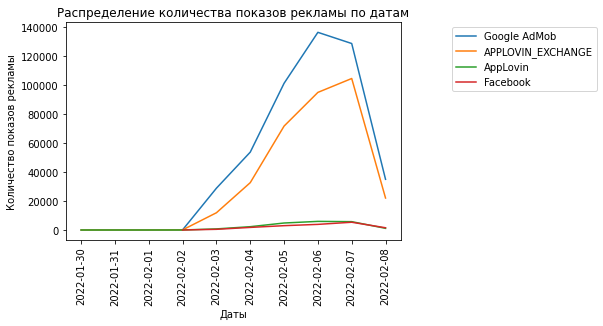

In [33]:
for network_name in df.network_name.unique():
    plt.plot(df[df['network_name']==network_name].pivot_table(
        index=df['event_datetime'].dt.round('1d'), values='event_name', aggfunc='count'))
plt.title(f'Распределение количества показов рекламы по датам')
plt.xlabel('Даты')
plt.ylabel('Количество показов рекламы')
plt.legend(df.network_name.unique(), loc=1, 
           bbox_to_anchor=(1.6, 1))
plt.xticks(rotation=90)
plt.show()

По количеству просмотров также лидирует Google AdMob, на втором месте APPLOVIN_EXCHANGE, который несмотря на большое количество просмотров является третьим по доходам из-за низкой цены просмотра.

<a id="analysis_conclusion"></a>
### Вывод

Отбросили 1% выбросов, представляющих экстремально-большие значения выручки. Наиболее дорогая реклама - rv, но у нее меньше всего просмотров, на втором месте int, самая часто просматриваемая, но с наименьшей выручкой - реклама banner. Наиболее популярная операционная система версии 12 - для нее же наибольшая выручка за просмотр рекламы. Выручка от рекламы падает по утрам - возможно в это время в игре меньше пользователей. Наиболее выгодная рекламная сеть - Google AdMod - у нее больше всего просмотров и наибольшая средняя eCPM.

<a id="conclusion"></a>
## Общий вывод

Проведен анализ данных о просмотрах рекламы в мобильной игре с 29 января по 7 февраля 2022 г.

Информация представлена в виде датасета из 15 колонок и 860079 строк, датасет содержит информацию о номере пользователя, устройстве, дате, размере вознаграждения за рекламу, городе, названия рекламного канала и др.

В ходе предобработки разбили колонку event_json на 17 новых и преобразовали колонки формата даты и времени, а также колонки формата вещественных чисел.

При анализе данных отбросили 1% выбросов, представляющих экстремально-большие значения выручки. 

Наиболее дорогая реклама - rv, но у нее меньше всего просмотров, на втором месте int, самая часто просматриваемая, но с наименьшей выручкой - реклама banner. Наиболее популярная операционная система версии 12 - для нее же наибольшая выручка за просмотр рекламы. Выручка от рекламы падает по утрам - возможно в это время в игре меньше пользователей. Наиболее выгодная рекламная сеть - Google AdMod - у нее больше всего просмотров и наибольшая средняя eCPM.
